In [30]:
import numpy as np
import os 
import glob
import json
from func import *
import ast
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score,roc_curve,auc
import pandas as pd
from sklearn.metrics import roc_auc_score
import shutil
from scipy.stats import sem
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 10

def CI_calc(gt_list, opt_prob_list):
    n_bootstraps = 1000
    rng_seed = 42  # control reproducibility
    bootstrapped_scores = []

    rng = np.random.RandomState(rng_seed)
    for m in range(n_bootstraps):
        y_true = np.array(gt_list)
        y_pred = np.array(opt_prob_list)
        # bootstrap by sampling with replacement on the prediction indices
        indices = rng.randint(0, len(y_pred), len(y_pred))
        if len(np.unique(y_true[indices])) < 2:
            # We need at least one positive and one negative sample for ROC AUC
            # to be defined: reject the sample
            continue

        score = roc_auc_score(y_true[indices], y_pred[indices])
        bootstrapped_scores.append(score)
    #             print("Bootstrap #{} ROC area: {:0.3f}".format(m + 1, score))

    sorted_scores = np.array(bootstrapped_scores)
    sorted_scores.sort()

    # Computing the lower and upper bound of the 90% confidence interval
    # You can change the bounds percentiles to 0.025 and 0.975 to get
    # a 95% confidence interval instead.
    confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
    confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
    
    return confidence_lower, confidence_upper



Thoracic radiologist
u2_u14
u3_u15
u4_u16
AUC_withoutAI : 0.886 (0.861, 0.911)
AUC_withAI : 0.894 (0.871, 0.919)
pvalue_a = 0.2036
pvalue_b = 0.0001

Pulmonologist 
u5_u17
u6_u18
u7_u19
AUC_withoutAI : 0.831 (0.804, 0.861)
AUC_withAI : 0.869 (0.842, 0.894)
pvalue_a = 0.0010
pvalue_b = 0.3220

Board-certified radiologist
u8_u20
u9_u21
u10_u22
AUC_withoutAI : 0.857 (0.829, 0.884)
AUC_withAI : 0.872 (0.844, 0.898)
pvalue_a = 0.2169
pvalue_b = 0.8527

Radiology resident
u11_u23
u12_u24
u13_u25
AUC_withoutAI : 0.843 (0.814, 0.873)
AUC_withAI : 0.875 (0.847, 0.901)
pvalue_a = 0.0003
pvalue_b = 0.0574


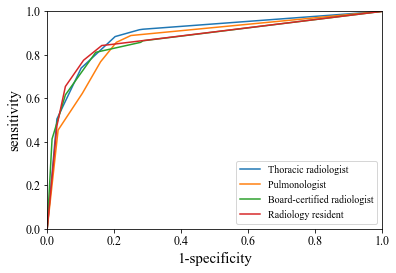

In [29]:
gt_path = './data/review_result_opt/respiratory'
opt_path = './data/cxr_opt_respiratory'
ai_path = './data/ai_json(opt)/respiratory/json_output'

ais =['without_AI','with_AI']
df = pd.DataFrame(columns = ['name','AI' ,'auc_score'])
group = ['Thoracic radiologist', 'Pulmonologist ', 'Board-certified radiologist', 'Radiology resident']

name=0
for i in range(2,14,3):
    print('\n'+group[name])
    
    opt_score_n = []
    opt_score_a = []
    gt_n = []
    gt_a = []
    ai_score_n = []
    
    for u in range(3):
        user1 = 'u'+str(i+u)
        user2 = 'u'+str(i+u+12)
        print(user1+'_'+user2)
    
        for k in range(len(ais)):
            df_2 = pd.DataFrame(columns = ['name', 'AI', 'gt' ,'opt', 'opt_prob'])

            gt_file = glob.glob(gt_path+'/*.json')
            opt_file = glob.glob(opt_path+'/'+user1+'_'+user2+'/'+ais[k]+'/*.json')
            ai_file = glob.glob(ai_path+'/*.json')
            
            for j in range(len(gt_file)):
                contours_gt, labels, w, h = json_gt_open(gt_file[j])
                contours_opt, contourIds, rating_list, rate = json_opt_open(opt_file[j])
                ai_prob = json_ai_open(ai_file[j])
    #             print(rating_list,rate)
                # gt        
                if not 'Invisible Nodule' in labels:
                    if contours_gt:
                        gt_label = 1
                        if k==0:
                            gt_n.append(1)
                        else:
                            gt_a.append(1)
                    else:
                        gt_label = 0
                        if k==0:
                            gt_n.append(0)
                        else:
                            gt_a.append(0)
                
                    # opt
                    if contours_opt:
                        opt_label = 1
                        opt_prob = rate/5
                        if k==0:
                            opt_score_n.append(rate/5)
                        else:
                            opt_score_a.append(rate/5)
                    else:
                        opt_label = 0
                        opt_prob = 0
                        if k==0:
                            opt_score_n.append(0)
                        else:
                            opt_score_a.append(0)
                            
                    # ai
                    if k==0:
                        ai_score_n.append(ai_prob)

    
    fp,tp,_=roc_curve(gt_n,opt_score_n)
    low, upper = CI_calc(gt_n, opt_score_n)
    print('AUC_withoutAI : %.3f (%.3f, %.3f)'%(auc(fp,tp),low, upper))
    
#     plt.plot(fp,tp,label='%s'%(group[name]))
#     plt.xlim([-0.0,1.0])
#     plt.ylim([-0.0,1.0])
#     plt.xlabel('1-specificity', fontsize=15)
#     plt.ylabel('sensitivity', fontsize=15)
#     plt.legend(loc='lower right')
#     plt.savefig("./roc/abnormal_respiratory_withoutAI.tif", dpi=300)
    
    fp,tp,_=roc_curve(gt_a,opt_score_a)
    low, upper = CI_calc(gt_a, opt_score_a)
    print('AUC_withAI : %.3f (%.3f, %.3f)'%(auc(fp,tp),low, upper))

    plt.plot(fp,tp,label='%s'%(group[name]))
    plt.xlim([-0.0,1.0])
    plt.ylim([-0.0,1.0])
    plt.xlabel('1-specificity', fontsize=15)
    plt.ylabel('sensitivity', fontsize=15)
    plt.legend(loc='lower right')
    plt.savefig("./roc/abnormal_respiratory_withAI.tif", dpi=300)
    
    _, p_value = stats.ttest_rel(opt_score_n, opt_score_a)
    print("pvalue_a = %.4f"%(p_value)) 
    
    _, p_value = stats.ttest_ind(opt_score_n, ai_score_n)
    print("pvalue_b = %.4f"%(p_value)) 
    name+=1

In [ ]:
len(ai_score_n), len(opt_score_n)


Thoracic radiologist
u2_u11
u3_u12
u4_u13
AUC_withoutAI : 0.715 (0.665, 0.762)
AUC_withAI : 0.721 (0.671, 0.766)
pvalue_a = 0.2132
pvalue_b = 0.0000

Board-certified radiologist
u5_u14
u6_u15
u7_u16
AUC_withoutAI : 0.694 (0.647, 0.740)
AUC_withAI : 0.704 (0.657, 0.751)
pvalue_a = 0.9409
pvalue_b = 0.0000

Radiology resident
u8_u17
u9_u18
u10_u19
AUC_withoutAI : 0.693 (0.646, 0.743)
AUC_withAI : 0.710 (0.664, 0.759)
pvalue_a = 0.9819
pvalue_b = 0.0000


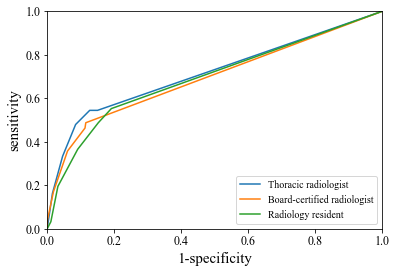

In [33]:
gt_path = './data/review_result_opt/healthcheck'
opt_path = './data/cxr_opt_healthcheck'
ai_path = './data/ai_json(opt)/healthcheck/json_output'

ais =['without_AI','with_AI']
df = pd.DataFrame(columns = ['name','AI' ,'auc_score'])
group = ['Thoracic radiologist', 'Board-certified radiologist', 'Radiology resident']

name=0
for i in range(2,11,3):
    print('\n'+group[name])
    opt_score_n = []
    opt_score_a = []
    gt_n = []
    gt_a = []
    ai_score_n=[]
    for u in range(3):
        user1 = 'u'+str(i+u)
        user2 = 'u'+str(i+u+9)
        print(user1+'_'+user2)
    
        for k in range(len(ais)):
            df_2 = pd.DataFrame(columns = ['name', 'AI', 'gt' ,'opt', 'opt_prob'])
        
            gt_file = glob.glob(gt_path+'/*.json')
            opt_file = glob.glob(opt_path+'/'+user1+'_'+user2+'/'+ais[k]+'/*.json')
            ai_file = glob.glob(ai_path+'/*.json')
        
            for j in range(len(gt_file)):
                contours_gt, labels, w, h = json_gt_open(gt_file[j])
                contours_opt, contourIds, rating_list, rate = json_opt_open(opt_file[j])
                ai_prob = json_ai_open(ai_file[j])
    #             print(rating_list,rate)
                # gt        
                if not 'Invisible Nodule' in labels:
                    if contours_gt:
                        gt_label = 1
                        if k==0:
                            gt_n.append(1)
                        else:
                            gt_a.append(1)
                    else:
                        gt_label = 0
                        if k==0:
                            gt_n.append(0)
                        else:
                            gt_a.append(0)
                
                    # opt
                    if contours_opt:
                        opt_label = 1
                        opt_prob = rate/5
                        if k==0:
                            opt_score_n.append(rate/5)
                        else:
                            opt_score_a.append(rate/5)
                    else:
                        opt_label = 0
                        opt_prob = 0
                        if k==0:
                            opt_score_n.append(0)
                        else:
                            opt_score_a.append(0)
                            
                    # ai
                    if k==0:
                        ai_score_n.append(ai_prob)

    fp,tp,_=roc_curve(gt_n,opt_score_n)
    low, upper = CI_calc(gt_n, opt_score_n)
    print('AUC_withoutAI : %.3f (%.3f, %.3f)'%(auc(fp,tp),low, upper))
    
    plt.plot(fp,tp,label='%s'%(group[name]))
    plt.xlim([-0.0,1.0])
    plt.ylim([-0.0,1.0])
    plt.xlabel('1-specificity', fontsize=15)
    plt.ylabel('sensitivity', fontsize=15)
    plt.legend(loc='lower right')
    plt.savefig("./roc/abnormal_healthcheck_withoutAI.tif", dpi=300)
    
    fp,tp,_=roc_curve(gt_a,opt_score_a)
    low, upper = CI_calc(gt_a, opt_score_a)
    print('AUC_withAI : %.3f (%.3f, %.3f)'%(auc(fp,tp),low, upper))

#     plt.plot(fp,tp,label='%s'%(group[name]))
#     plt.xlim([-0.0,1.0])
#     plt.ylim([-0.0,1.0])
#     plt.xlabel('1-specificity', fontsize=15)
#     plt.ylabel('sensitivity', fontsize=15)
#     plt.legend(loc='lower right')
#     plt.savefig("./roc/abnormal_healthcheck_withAI.tif", dpi=300)
    
    _, p_value = stats.ttest_rel(opt_score_n, opt_score_a)
    print("pvalue_a = %.4f"%(p_value)) 
    
    _, p_value = stats.ttest_ind(opt_score_n, ai_score_n)
    print("pvalue_b = %.4f"%(p_value)) 
    name+=1